<div class="usecase-title">Real Estate Market Analysis and Forecasting</div>

<div class="usecase-authors"><b>Authored by: </b> Vivek Olladapu</div>

<div class="usecase-duration"><b>Duration:</b> 90 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python, matpotlib, numpy</div>
</div>

<div class="usecase-section-header">Scenario</div>

Urban growth and real estate development are influenced by several factors, including location, nearby infrastructure, and historical construction patterns. In a rapidly developing city like Melbourne, the ability to monitor and predict where development is taking place, and understand the reasons behind it, is essential for effective urban planning, informed investment decisions, and policy-making.

This use case focuses on analyzing historical building permits and development activity across suburbs in Melbourne using publicly available datasets. The analysis is enriched with data on surrounding landmarks and infrastructure, such as schools, hospitals, and places of worship, to examine how proximity to these amenities impacts development patterns.

Time series analysis techniques are used to identify historical trends and generate forecasts using ARIMA models. The findings are presented through interactive maps and trend plots, offering clear visual insights into development activity across the city. This approach helps to understand the growth patterns in Melbourne and provides a foundation for anticipating future development.

<div class="usecase-section-header">What this use case will teach you</div>

At the end of this use case you will:
- How to fetch real estate and infrastructure data from Melbourne’s Open Data portal using APIs.
- Clean and preprocess raw geospatial and time series datasets using Python and pandas.
- Perform time-based trend analysis of development activity across suburbs.
- Apply time series forecasting using ARIMA to predict future developments.
- Visualize insights using interactive maps and trend plots.
- Identify relationships between development hotspots and nearby public landmarks.

# Importing Required Libraries


In [2]:
!pip install folium
import requests
import pandas as pd
import folium
from io import StringIO
from folium.plugins import MarkerCluster, HeatMap
import matplotlib.pyplot as plt

# Importing Datasets

Reading first data set through API for the building permits

In [7]:
# Set the base URL and dataset ID for Melbourne Open Data
base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
dataset_id = 'building-permits'
# Build the full export URL for CSV format
url = f'{base_url}{dataset_id}/exports/csv'
# Define parameters for the API request
params = {
    'select': '*',
    'limit': -1,
    'lang': 'en',
    'timezone': 'UTC'
}
# Send request to the API
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Read the CSV content into a DataFrame
    url_content = response.content.decode('utf-8')
    development_df = pd.read_csv(StringIO(url_content), delimiter=';')
    # Print first 10 rows
    print(development_df.head(10))
else:
    # Print error message if request fails
    print(f'Request failed with status code {response.status_code}')


    council_ref                permit_number  issue_date  \
0  BP-2022-1306    CBSU58176/3153502818228/1  2022-12-20   
1  BP-2022-1306  CBSU58176/3153502818228/1/A  2023-01-24   
2  BP-2022-1306  CBSU58176/3153502818228/1/A  2022-12-20   
3  BP-2022-1306  CBSU58176/3153502818228/1/A  2022-09-02   
4  BP-2022-1305                7730751768797  2023-08-08   
5  BP-2022-1307                2466655253189  2023-07-05   
6  BP-2022-1307                2466655253189  2022-06-16   
7  BP-2022-1304    BS-U 1177 / 6542067388817  2022-08-31   
8  BP-2022-1302                1691096586466  2023-08-14   
9  BP-2022-1301       BSU-1013/6523785816215  2023-04-20   

                                             address  \
0       Southgate 16-60 City Road SOUTHBANK VIC 3006   
1       Southgate 16-60 City Road SOUTHBANK VIC 3006   
2       Southgate 16-60 City Road SOUTHBANK VIC 3006   
3       Southgate 16-60 City Road SOUTHBANK VIC 3006   
4  Docklands Studios Melbourne 458-490 Docklands ...   
5  

This dataset shows details about building permits issued in Melbourne. Some buildings have multiple permits because big projects are done in stages. Expensive projects, like those costing over $100 million, are mostly in busy areas such as Melbourne city and Southbank. The permits include different types like building permits, occupancy permits, and final inspection certificates, which show the progress of a project from start to finish. The dates also show that construction usually takes 2 to 3 years to complete. The address column tells us where each project is happening, and the estimated cost helps us understand how big or small the project is.

Reading second dataset through API for the landmarks for public places 

In [9]:
# Set the base URL and dataset ID for Melbourne Open Data
base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
dataset_id = 'landmarks-and-places-of-interest-including-schools-theatres-health-services-spor'
# Build the full URL to download the dataset as CSV
url = f'{base_url}{dataset_id}/exports/csv'
# Define basic parameters for the API request
params = {
    'select': '*',
    'limit': -1,
    'lang': 'en',
    'timezone': 'UTC'
}
# Send the request to the API
response = requests.get(url, params=params)
# If the request is successful, process the data
if response.status_code == 200:
    url_content = response.content.decode('utf-8')
    landmarks_df = pd.read_csv(StringIO(url_content), delimiter=';')
    print(landmarks_df.head(10))  # Display first 10 rows
else:
    # Print error message if request fails
    print(f'Request failed with status code {response.status_code}')


              theme           sub_theme                     feature_name  \
0  Place of Worship              Church                St Francis Church   
1  Place of Worship              Church                  St James Church   
2  Place of Worship              Church        St Mary's Anglican Church   
3  Place of Worship              Church                     Scots Church   
4  Place of Worship              Church      St Michael's Uniting Church   
5  Place of Worship              Church            Greek Orthodox Church   
6  Place of Worship              Church          North Melbourne Uniting   
7  Place of Worship              Church  South Yarra Presbyterian Church   
8  Place of Worship           Synagogue         East Melbourne Synagogue   
9         Transport  Transport Terminal                Port of Melbourne   

                          co_ordinates  
0  -37.8118847831837, 144.962422614541  
1  -37.8101281201969, 144.952468571683  
2  -37.8031663672997, 144.953761537074  

This dataset lists important public places in Melbourne, like churches, synagogues, and transport terminals. These locations are helpful for understanding the local community and urban setup. Each place includes coordinates, which makes it easy to map them and see how close they are to residential or development areas. This can be useful when studying how nearby landmarks might affect property value or planning decisions.

Importing the third dataset throgh API for development activity 

In [11]:
# Set the base URL and dataset ID for Melbourne Open Data
base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
dataset_id = 'development-activity-monitor'
# Build the full URL to download the dataset as CSV
url = f'{base_url}{dataset_id}/exports/csv'
# Define basic parameters for the API request
params = {
    'select': '*',
    'limit': -1,
    'lang': 'en',
    'timezone': 'UTC'
}
# Send the request to the API
response = requests.get(url, params=params)
# If the request is successful, process the data
if response.status_code == 200:
    url_content = response.content.decode('utf-8')
    permits_df = pd.read_csv(StringIO(url_content), delimiter=';')
    print(permits_df.head(10))  # Display first 10 rows
else:
    # Print error message if request fails
    print(f'Request failed with status code {response.status_code}')

  data_format development_key     status  year_completed  \
0  Pre May 16         X000568  COMPLETED          2012.0   
1  Pre May 16         X000557  COMPLETED          2002.0   
2  Pre May 16         X000448  COMPLETED          2015.0   
3  Pre May 16         X000458  COMPLETED          2004.0   
4  Pre May 16         X000996  COMPLETED          2013.0   
5  Pre May 16         X000955  COMPLETED          2002.0   
6  Pre May 16         X000404  COMPLETED          2013.0   
7  Pre May 16         X000532  COMPLETED          2003.0   
8  Pre May 16         X000122  COMPLETED          2010.0   
9  Pre May 16         X000124  COMPLETED          2006.0   

                clue_small_area  clue_block  \
0  West Melbourne (Residential)         411   
1  West Melbourne (Residential)         401   
2               North Melbourne         314   
3               North Melbourne         330   
4               North Melbourne        1012   
5                     Parkville         903   
6         

This dataset provides information about completed development projects in Melbourne. Each row shows details like the year a project was completed, the suburb, exact address, and coordinates. This data helps identify development patterns and active growth zones across Melbourne.

# Data Preprocessing and Exploratory Data Analysis

In [13]:
# Drop unnecessary columns from the dataset
permits_df_cleaned = development_df.drop(columns=[
    'rbs_number', 'commence_by_date', 'completed_by_date',
    'permit_certificate_type', 'desc_of_works', 'council_ref'
])

# Remove rows where issue_date is missing
permits_df_cleaned = permits_df_cleaned.dropna(subset=['issue_date'])

# Convert issue_date column to datetime format
permits_df_cleaned['issue_date'] = pd.to_datetime(permits_df_cleaned['issue_date'], errors='coerce')

# Extract suburb name from the address (assuming it's before "VIC")
permits_df_cleaned['suburb'] = permits_df_cleaned['address'].str.extract(r'\b([A-Z\s]+)\sVIC\b')

# Remove rows where suburb couldn't be extracted
permits_df_cleaned = permits_df_cleaned.dropna(subset=['suburb'])

# Extract year from the issue_date
permits_df_cleaned['year'] = permits_df_cleaned['issue_date'].dt.year

# Group data by suburb and year, and count the number of permits
permits_aggregated = permits_df_cleaned.groupby(['suburb', 'year']).size().reset_index(name='permit_count')

# Display the first few rows of the aggregated data
print(permits_aggregated.head())


     suburb  year  permit_count
0   CARLTON  1994            17
1   CARLTON  1995            81
2   CARLTON  1996           111
3   CARLTON  1997           111
4   CARLTON  1998           216


The output shows a steady rise in the number of permits issued in the Carlton suburb between 1994 and 1998. For example, only 17 permits were issued in 1994, but this number rose sharply to 216 by 1998. This indicates a period of high construction and development activity in Carlton during the mid-to-late 1990s. These insights are valuable for identifying periods of growth and understanding how development evolved across different regions in Melbourne.

In [15]:
# Define columns to remove if they exist in the DataFrame
columns_to_drop = ['property_id_2', 'property_id_3', 'property_id_4', 'property_id_5',
                   'data_format', 'development_key', 'property_id',
                   'town_planning_application', 'geopoint']

# Keep only the columns that are present in the actual DataFrame
existing_cols = [col for col in columns_to_drop if col in permits_df.columns]

# Drop the unnecessary columns
development_df_cleaned = permits_df.drop(columns=existing_cols)

# Drop rows that are missing essential data like year or location
required_cols = [col for col in ['year_completed', 'latitude', 'longitude'] if col in development_df_cleaned.columns]
development_df_cleaned = development_df_cleaned.dropna(subset=required_cols)

# Convert the year column to integer type
if 'year_completed' in development_df_cleaned.columns:
    development_df_cleaned['year_completed'] = development_df_cleaned['year_completed'].astype(int)

# If available, group the data by suburb and year, and count developments
if 'clue_small_area' in development_df_cleaned.columns:
    development_aggregated = development_df_cleaned.groupby(['clue_small_area', 'year_completed']).size().reset_index(name='development_count')
    print(development_aggregated.head())


  clue_small_area  year_completed  development_count
0         Carlton            2002                  3
1         Carlton            2003                  9
2         Carlton            2004                  2
3         Carlton            2005                  4
4         Carlton            2006                  6


This output shows the number of developments completed in Carlton between 2002 and 2006. While the numbers are relatively small, the steady yearly activity suggests ongoing development in the area. This type of aggregation helps to track long-term trends and spot which suburbs have been consistently growing or experiencing development spikes.

# Plotting Trends from the data based on the suburbs


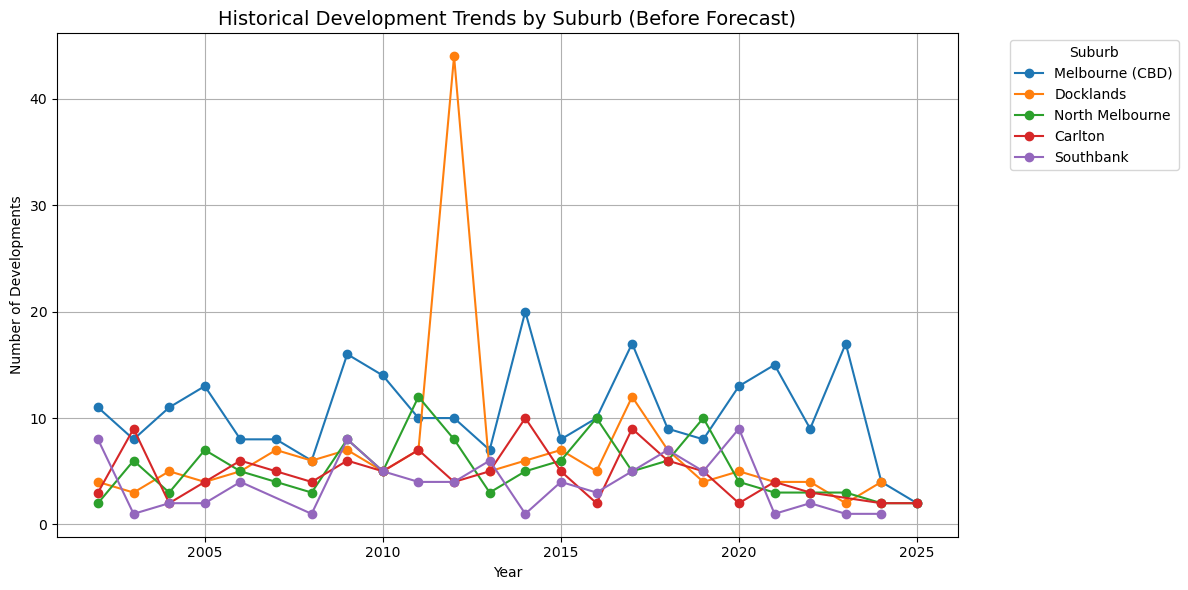

In [17]:
# Historical data: actual developments per year per suburb
historical_trends = development_df_cleaned.groupby(['clue_small_area', 'year_completed']).size().reset_index(name='count')

# Pick top 5 most active suburbs
top_suburbs = historical_trends.groupby('clue_small_area')['count'].sum().nlargest(5).index.tolist()

plt.figure(figsize=(12, 6))

# Plot historical trend lines
for suburb in top_suburbs:
    suburb_data = historical_trends[historical_trends['clue_small_area'] == suburb]
    plt.plot(suburb_data['year_completed'], suburb_data['count'], marker='o', label=suburb)

# Aesthetics
plt.title('Historical Development Trends by Suburb (Before Forecast)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Number of Developments')
plt.legend(title='Suburb', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


This line graph shows the number of developments completed each year across the five most active suburbs in Melbourne. Melbourne (CBD) had the highest and most consistent development activity throughout the years, with notable peaks around 2010, 2015, and 2020. Docklands shows a sharp spike in development around 2010, indicating a concentrated burst of projects during that time. North Melbourne, Carlton, and Southbank present relatively stable development patterns, with occasional fluctuations but no significant surges. The chart provides a clear view of historical development distribution and highlights the areas with sustained construction growth over time.

In [21]:
# Initialize base map centered on Melbourne
initial_map = folium.Map(location=[-37.8136, 144.9631], zoom_start=13)

# --- Development Markers Cluster ---
dev_cluster = MarkerCluster(name='Developments').add_to(initial_map)
for idx, row in development_df_cleaned.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['street_address']}<br>Year: {row['year_completed']}",
        icon=folium.Icon(color='blue', icon='home', prefix='glyphicon')
    ).add_to(dev_cluster)

# --- Development Heatmap ---
heat_data = development_df_cleaned[['latitude', 'longitude']].dropna().values.tolist()
HeatMap(heat_data, name='Development Heatmap', radius=10).add_to(initial_map)

# --- Amenities (Landmarks) Layers ---
themes = landmarks_df['theme'].unique()
icons = {
    'Place of Worship': 'cloud', 'Education': 'education', 'Health Services': 'plus-sign',
    'Transport': 'road', 'Community Use': 'user', 'Entertainment': 'music',
    'Sport': 'flag', 'Tourist Attraction': 'star'
}

for theme in themes:
    group = folium.FeatureGroup(name=theme).add_to(initial_map)
    for idx, row in landmarks_df[landmarks_df['theme'] == theme].iterrows():
        try:
            lat, lon = map(float, row['co_ordinates'].split(','))
            folium.Marker(
                location=[lat, lon],
                popup=row['feature_name'],
                icon=folium.Icon(icon=icons.get(theme, 'info-sign'), color='green')
            ).add_to(group)
        except:
            continue  # skip invalid coordinate rows

# Adding Layer Control
folium.LayerControl().add_to(initial_map)

# --- Save the Map ---
initial_map.save('initial_interactive_map.html')

from IPython.display import IFrame
IFrame('initial_interactive_map.html', width=700, height=500)

The interactive map provides a comprehensive view of development activity in Melbourne alongside key public landmarks. Clusters of green markers represent different types of amenities such as places of worship, transport hubs, educational institutions, and health services. Blue markers indicate the locations of completed developments, grouped using marker clustering for better visual clarity. The overlaid heatmap highlights areas with high concentrations of development activity, particularly near the city center and surrounding key infrastructure. The map’s layer control allows users to toggle visibility of different themes, enabling focused analysis of how development patterns relate to nearby facilities. This visualization effectively shows the spatial distribution of developments and their proximity to important public services, making it useful for urban planning and real estate analysis.

# ARIMA Model Forecasting

In [23]:

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

forecast_results = []

# Perform ARIMA forecasting for all suburbs
for suburb in development_df_cleaned['clue_small_area'].unique():
    suburb_data = development_df_cleaned[development_df_cleaned['clue_small_area'] == suburb]
    suburb_ts = suburb_data['year_completed'].value_counts().sort_index()

    if len(suburb_ts) > 3:  # Ensuring sufficient data points for forecasting
        model = ARIMA(suburb_ts, order=(1, 1, 1)).fit()
        forecast = model.get_forecast(steps=5).summary_frame()
        forecast['suburb'] = suburb
        forecast['year'] = range(suburb_ts.index.max()+1, suburb_ts.index.max()+6)
        forecast_results.append(forecast)

# Combine all forecast data
all_suburbs_forecast_df = pd.concat(forecast_results).reset_index(drop=True)
all_suburbs_forecast_df.head()


count,mean,mean_se,mean_ci_lower,mean_ci_upper,suburb,year
0,3.869237,2.050154,-0.148991,7.887464,West Melbourne (Residential),2026
1,3.432774,2.079251,-0.642482,7.508031,West Melbourne (Residential),2027
2,3.499168,2.165696,-0.745517,7.743853,West Melbourne (Residential),2028
3,3.489068,2.238523,-0.898357,7.876493,West Melbourne (Residential),2029
4,3.490605,2.310533,-1.037957,8.019167,West Melbourne (Residential),2030


The ARIMA model forecasts a consistent level of development activity in West Melbourne (Residential) from 2026 to 2030, reflecting a steady demand for residential growth in this area. Starting with an estimated 3.87 developments in 2026, the trend maintains around 3.49 developments annually through to 2030, indicating that West Melbourne is poised to remain an active hub for residential projects. This sustained activity highlights the suburb’s ongoing appeal and its role in supporting Melbourne’s urban expansion.

# Forecasted Development Activity Hotspots Across Melbourne Suburbs

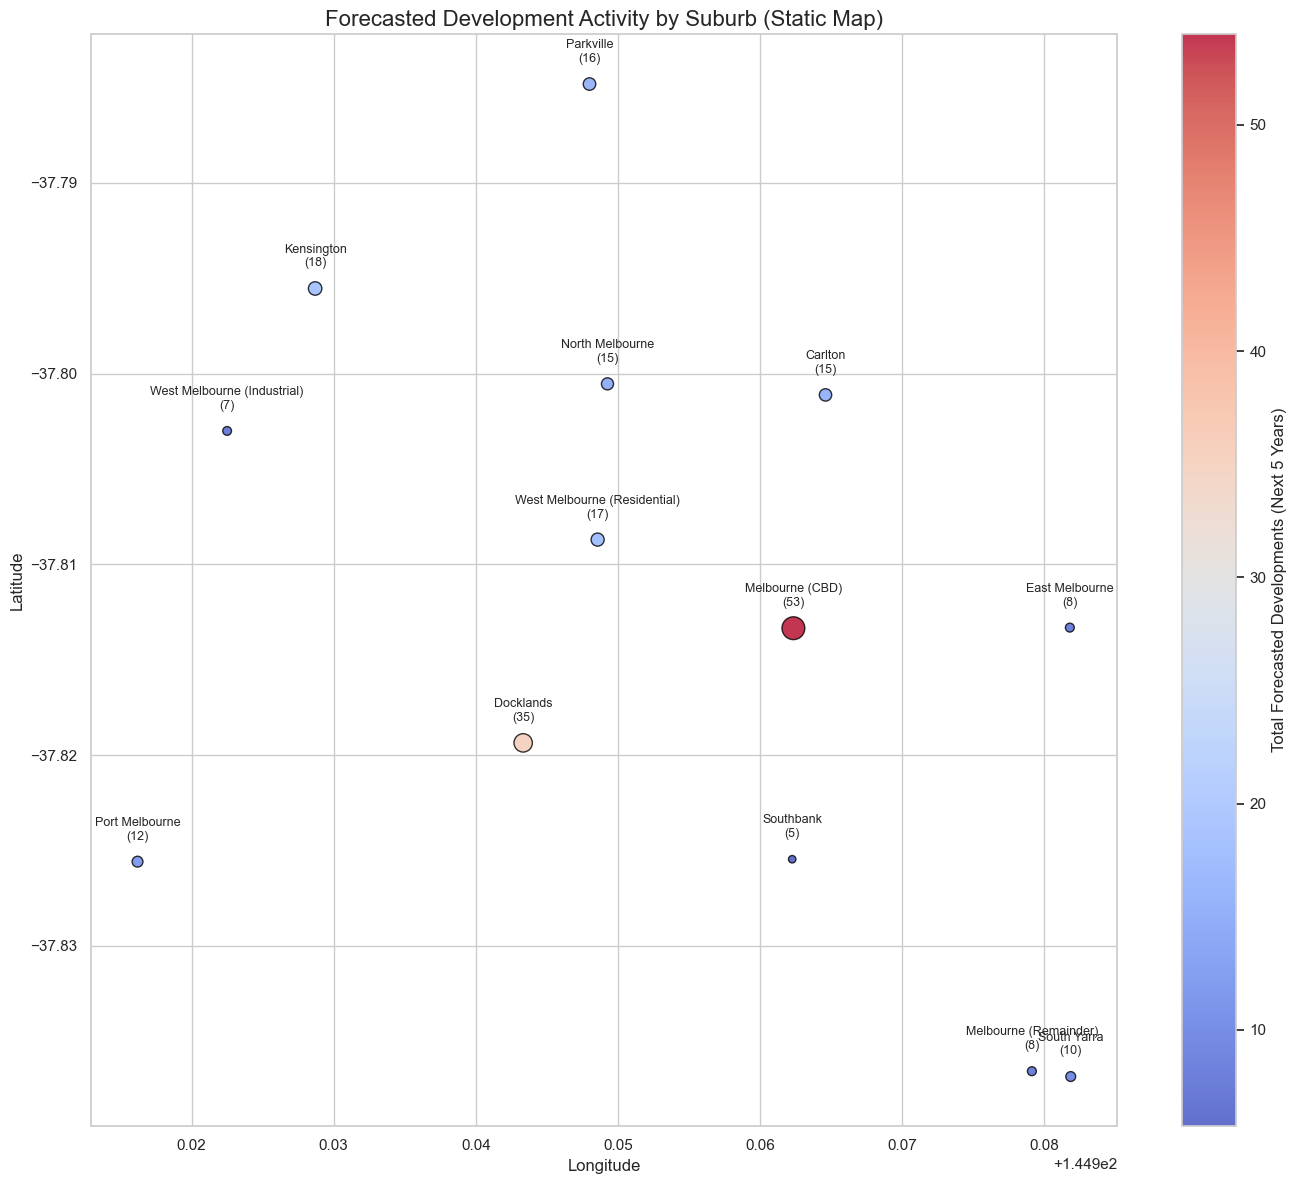

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Merge forecast totals with average coordinates per suburb
forecast_summary = all_suburbs_forecast_df.groupby('suburb')['mean'].sum().reset_index(name='total_forecast')
coords_df = development_df_cleaned.groupby('clue_small_area')[['latitude', 'longitude']].mean().reset_index()
coords_df.columns = ['suburb', 'latitude', 'longitude']
forecast_map_data = pd.merge(forecast_summary, coords_df, on='suburb', how='inner')

# Sort so larger bubbles are plotted last (on top)
forecast_map_data = forecast_map_data.sort_values(by='total_forecast')

# Setup the plot
plt.figure(figsize=(14, 12))
sns.set(style="whitegrid")

# Bubble plot
scatter = plt.scatter(
    forecast_map_data['longitude'],
    forecast_map_data['latitude'],
    s=forecast_map_data['total_forecast'] * 5,  # Scale for visibility
    c=forecast_map_data['total_forecast'],
    cmap='coolwarm',
    alpha=0.8,
    edgecolors='black'
)

# Add text labels
for idx, row in forecast_map_data.iterrows():
    plt.text(
        row['longitude'],
        row['latitude'] + 0.001,  # Slight offset to avoid overlap
        f"{row['suburb']}\n({int(row['total_forecast'])})",
        fontsize=9,
        ha='center',
        va='bottom'
    )

# Aesthetics
plt.colorbar(scatter, label='Total Forecasted Developments (Next 5 Years)')
plt.title('Forecasted Development Activity by Suburb (Static Map)', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.tight_layout()
plt.show()


The forecasted development activity map highlights Melbourne CBD as the primary growth hub with 53 projected developments over the next five years. Surrounding areas like Docklands (35 developments) and West Melbourne (Residential) (17 developments) also show significant growth, indicating continued urban expansion near the city center. Moderate activity is anticipated in suburbs such as Parkville, Kensington, and North Melbourne, while areas like Southbank and East Melbourne are expected to experience relatively lower development activity during this period.

# Forecasted Annual Development Trends Across Key Melbourne Suburbs (2024–2030)

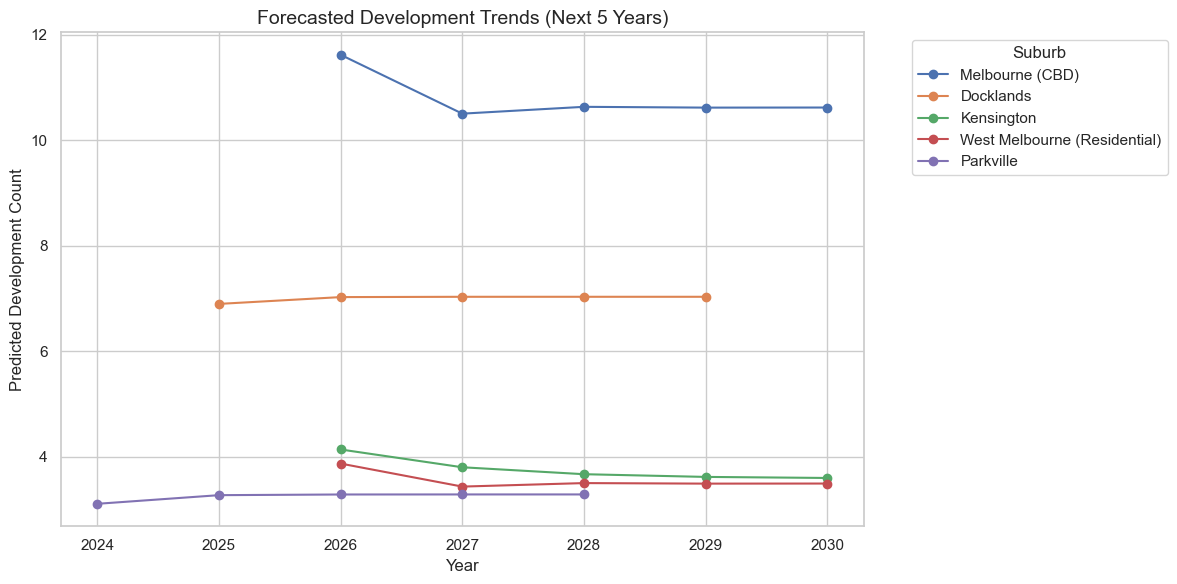

In [27]:
import matplotlib.pyplot as plt

# Pick top 5 most active suburbs for clarity
top_suburbs = all_suburbs_forecast_df.groupby('suburb')['mean'].sum().nlargest(5).index.tolist()

plt.figure(figsize=(12, 6))

# Plot each suburb's forecast line
for suburb in top_suburbs:
    data = all_suburbs_forecast_df[all_suburbs_forecast_df['suburb'] == suburb]
    plt.plot(data['year'], data['mean'], marker='o', label=suburb)

# Aesthetics
plt.title('Forecasted Development Trends (Next 5 Years)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Predicted Development Count')
plt.legend(title='Suburb', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


The forecasted development trends over the next five years highlight Melbourne CBD as the dominant growth area, consistently maintaining a high predicted development count of around 11 projects per year. Docklands also shows stable development activity, averaging 7 projects annually, indicating sustained interest in waterfront developments. Suburbs like Kensington, West Melbourne (Residential), and Parkville reflect moderate but steady growth, each maintaining around 3 to 4 developments per year. This trend showcases a balanced mix of high-density urban development and moderate residential expansion in surrounding suburbs.

# Interactive Visual Map

In [29]:


from folium.plugins import HeatMap, MarkerCluster

# Create base map again for clarity
final_map = folium.Map(location=[-37.8136, 144.9631], zoom_start=13)

# Development clustered points
dev_cluster_final = MarkerCluster(name='Developments').add_to(final_map)
for idx, row in development_df_cleaned.iterrows():
    folium.Marker(
        [row['latitude'], row['longitude']],
        popup=row['street_address'],
        icon=folium.Icon(color='blue', icon='home', prefix='glyphicon')
    ).add_to(dev_cluster_final)

# Amenities categorized safely with coordinate validation
for theme in themes:
    group = folium.FeatureGroup(name=theme).add_to(final_map)
    theme_df = landmarks_df[landmarks_df['theme'] == theme]

    for idx, row in theme_df.iterrows():
        if isinstance(row['co_ordinates'], str) and ',' in row['co_ordinates']:
            lat, lon = map(float, row['co_ordinates'].split(','))
            folium.Marker(
                [lat, lon],
                popup=row['feature_name'],
                icon=folium.Icon(icon=icons.get(theme, 'info-sign'), color='green')
            ).add_to(group)

# Forecast heatmap layer
forecast_df = development_df_cleaned.groupby('clue_small_area').size().reset_index(name='forecast_count')
forecast_df['intensity'] = (forecast_df['forecast_count'] - forecast_df['forecast_count'].min()) / \
                           (forecast_df['forecast_count'].max() - forecast_df['forecast_count'].min())
forecast_merged = development_df_cleaned.merge(forecast_df, on='clue_small_area')

heatmap_data = [
    [row['latitude'], row['longitude'], row['intensity']]
    for idx, row in forecast_merged.iterrows()
]
HeatMap(
    heatmap_data,
    radius=25,
    gradient={
        str(0.2): 'green',
        str(0.5): 'yellow',
        str(0.8): 'red'
    },
    name='Forecast Heatmap'
).add_to(final_map)


# Add interactive layer controls
folium.LayerControl().add_to(final_map)

# Save final interactive map with forecast heatmap
final_map.save('final_interactive_forecast_map.html')
final_map



This interactive map offers a clear visualization of projected development activity across Melbourne based on ARIMA forecasting results. The overlaid forecast heatmap highlights areas expected to experience significant future growth, with red zones indicating the highest forecasted development intensity. Clusters of green markers continue to represent important public amenities, while blue markers show the locations of existing developments. This combination allows users to analyze both current infrastructure and anticipated future expansion. The map’s layer control enables easy toggling between different categories and forecast data, supporting focused exploration of future growth patterns in relation to key public services and facilities. This visualization serves as a valuable tool for urban planners, policymakers, and investors to make informed, data-driven decisions regarding future development opportunities.

# Top 10 Melbourne Suburbs by Forecasted Development Activity

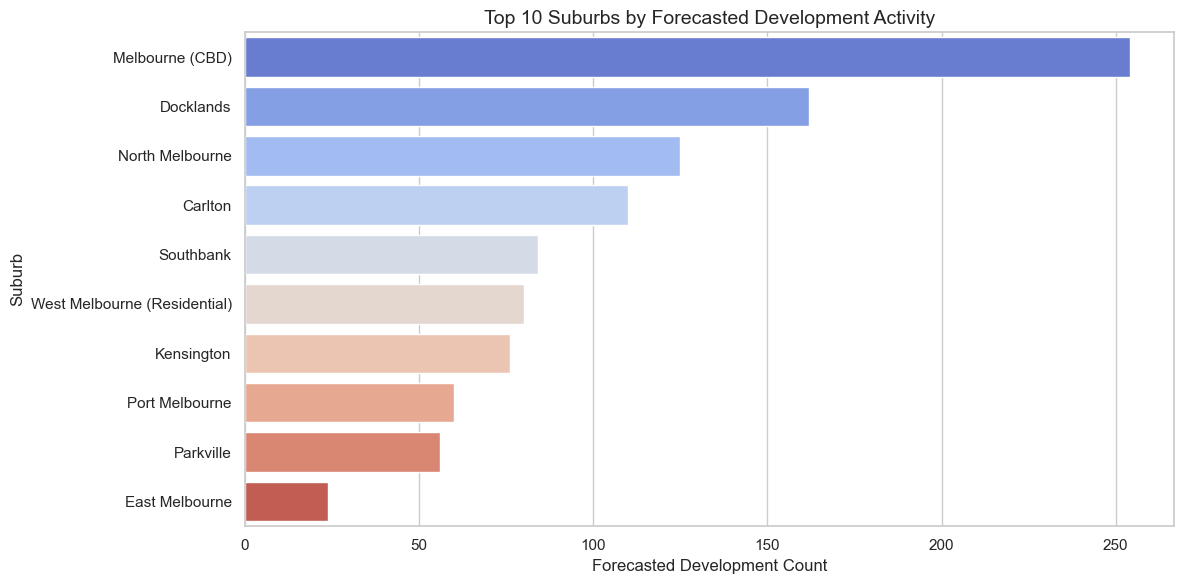

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get forecasted counts per suburb
forecast_df = development_df_cleaned.groupby('clue_small_area').size().reset_index(name='forecast_count')
top_forecast_df = forecast_df.sort_values(by='forecast_count', ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_forecast_df, x='forecast_count', y='clue_small_area', palette='coolwarm')

plt.title('Top 10 Suburbs by Forecasted Development Activity', fontsize=14)
plt.xlabel('Forecasted Development Count')
plt.ylabel('Suburb')
plt.tight_layout()
plt.show()


The chart shows that Melbourne CBD is expected to have the highest development activity, followed by Docklands and North Melbourne. Suburbs like Carlton, Southbank, and West Melbourne (Residential) also show moderate development levels. Areas such as Parkville and East Melbourne have lower forecasted activity, indicating less new development planned in these suburbs.